# Visualizing the Performance of the Actor Critic Agent

In [1]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']="-1"

import gym
import sys
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import clear_output

import cube_gym
from a2c import ActorCritic
from policy import *
from common.multiprocessing_env import SubprocVecEnv

##### The *env_fn* gives you the oppurtunity to configure the environment.

In [2]:
def env_fn():
    env = gym.make('cube-x2-v0')
    env.unwrapped._refresh(1,2,scramble_easy=False)
    return env

# This is just so we have the action list available to us
actions = env_fn().unwrapped.action_list
print('List of Actions')
for a in actions:
    print(a, end=' ')

List of Actions
r l u d f b .r .l .u .d .f .b 

In [3]:
nenvs = 4
envs = SubprocVecEnv([env_fn for _ in range(nenvs)])
envs.seed(int(time.time()))

### Setup TensorFlow and the Actor-Critic Model

In [4]:
sess = tf.Session()

actor_critic = ActorCritic(sess, CnnPolicy,
        envs.observation_space.shape, envs.action_space, 1, 5,
        0.5, 0.01, 0.5, 7e-4, 0.99, 1e-5, False)

# Modify this to where you saved the weights
# from training the actor critic model.

actor_critic.load("./experiments/a2c/weights/3000.ckpt")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from ./experiments/a2c/weights/3000.ckpt


### Now its time to do a test run on the environment

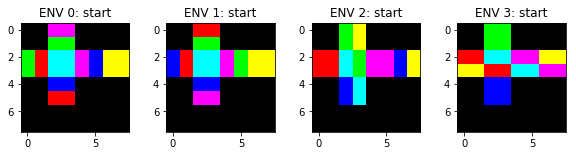

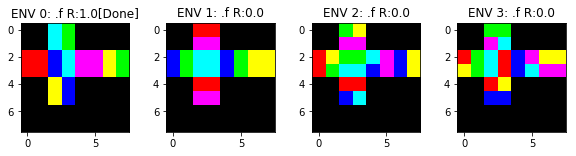

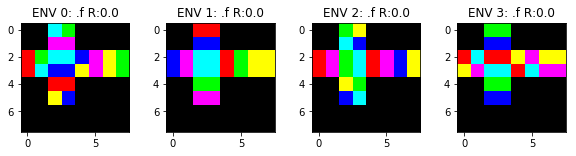

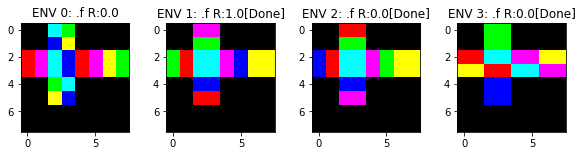

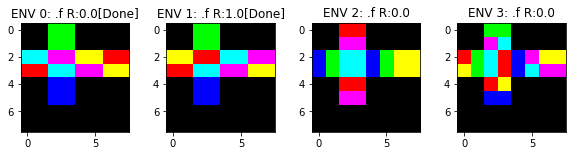

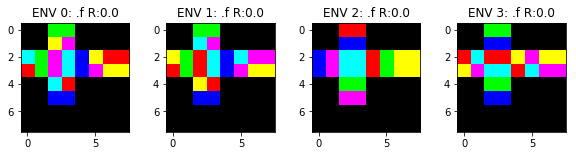

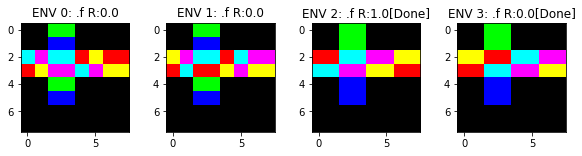

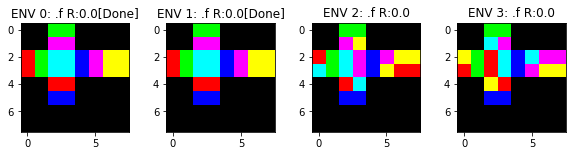

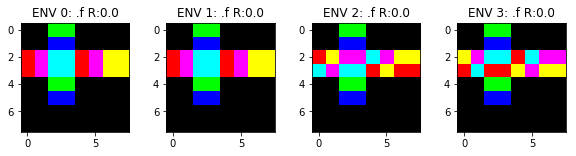

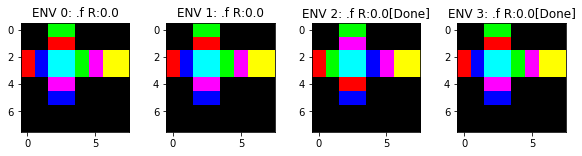

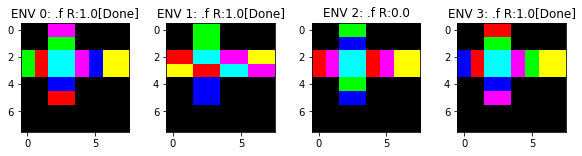

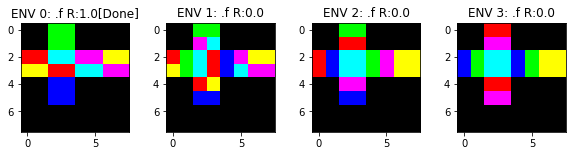

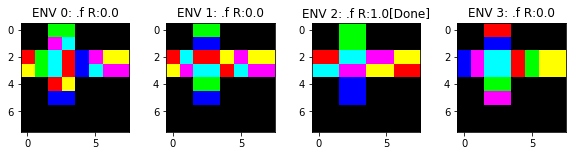

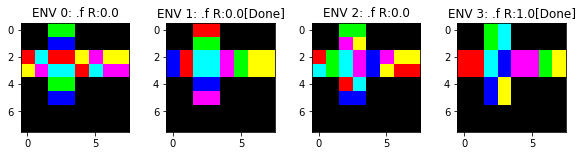

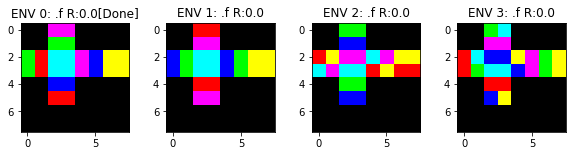

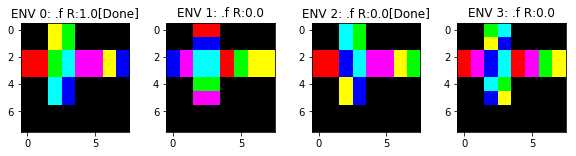

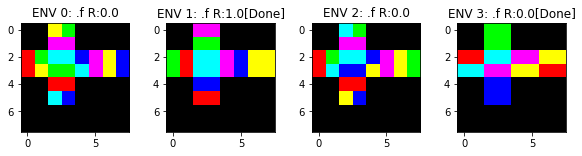

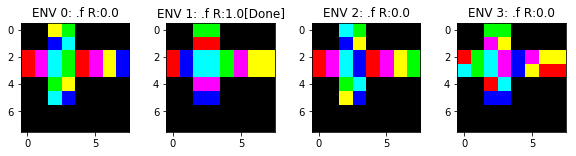

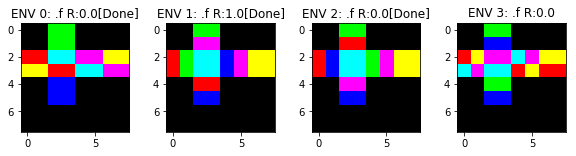

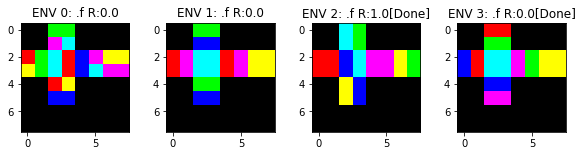

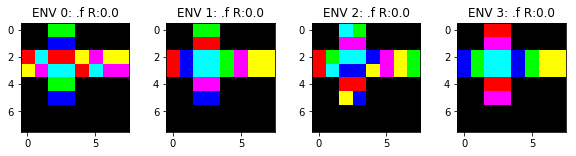

In [5]:
# This will draw out the observations of multiple environments
def show_states(obs, name):
    plt.figure(figsize=(10, 2))
    for e in range(nenvs):
        plt.subplot(1, nenvs, e+1)
        plt.title('ENV ' + str(e) + ': ' + name[e])
        plt.imshow(cube_gym.onehotToRGB(obs[e]))
    plt.show()

# Show all the starting observations
obs = envs.reset()
show_states(obs, ['start' for _ in range(nenvs)])
def title(a, r ,d):
    if d:
        return actions[a]+' R:'+str(r)+'[Done]'
    else:
        return actions[a]+' R:'+str(r)
    
d = False
for n in range(20):

    a, _, _ = actor_critic.act(obs, stochastic=False)
    obs, r, d, _ = envs.step(a)

    show_states(obs, [title(x,y,z) for x,y,z in zip(a,r,d)])